In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
torch.cuda.is_available()

True

In [2]:
x_0s = torch.arange(start=0, end=4, step=0.01, dtype=torch.float32, device='cuda')

In [3]:
def logistic_function_22_2nd_iterate(initial_value: float) -> float:
    '''
    implements two iterationa of the logistic fucntion with
    fixed parameter value of 2.2
    '''
    x_1 = 2.2 * initial_value * (1 - initial_value)
    return 2.2 * x_1 * (1 - x_1)

In [4]:
ys_2 = torch.func.vmap(logistic_function_22_2nd_iterate)(x_0s)     # outputs after second iteration

In [5]:
max(ys_2), min(ys_2)

(tensor(0.5500, device='cuda:0'), tensor(-1573.2426, device='cuda:0'))

In [6]:
xs_plot = x_0s
ys_plot = ys_2

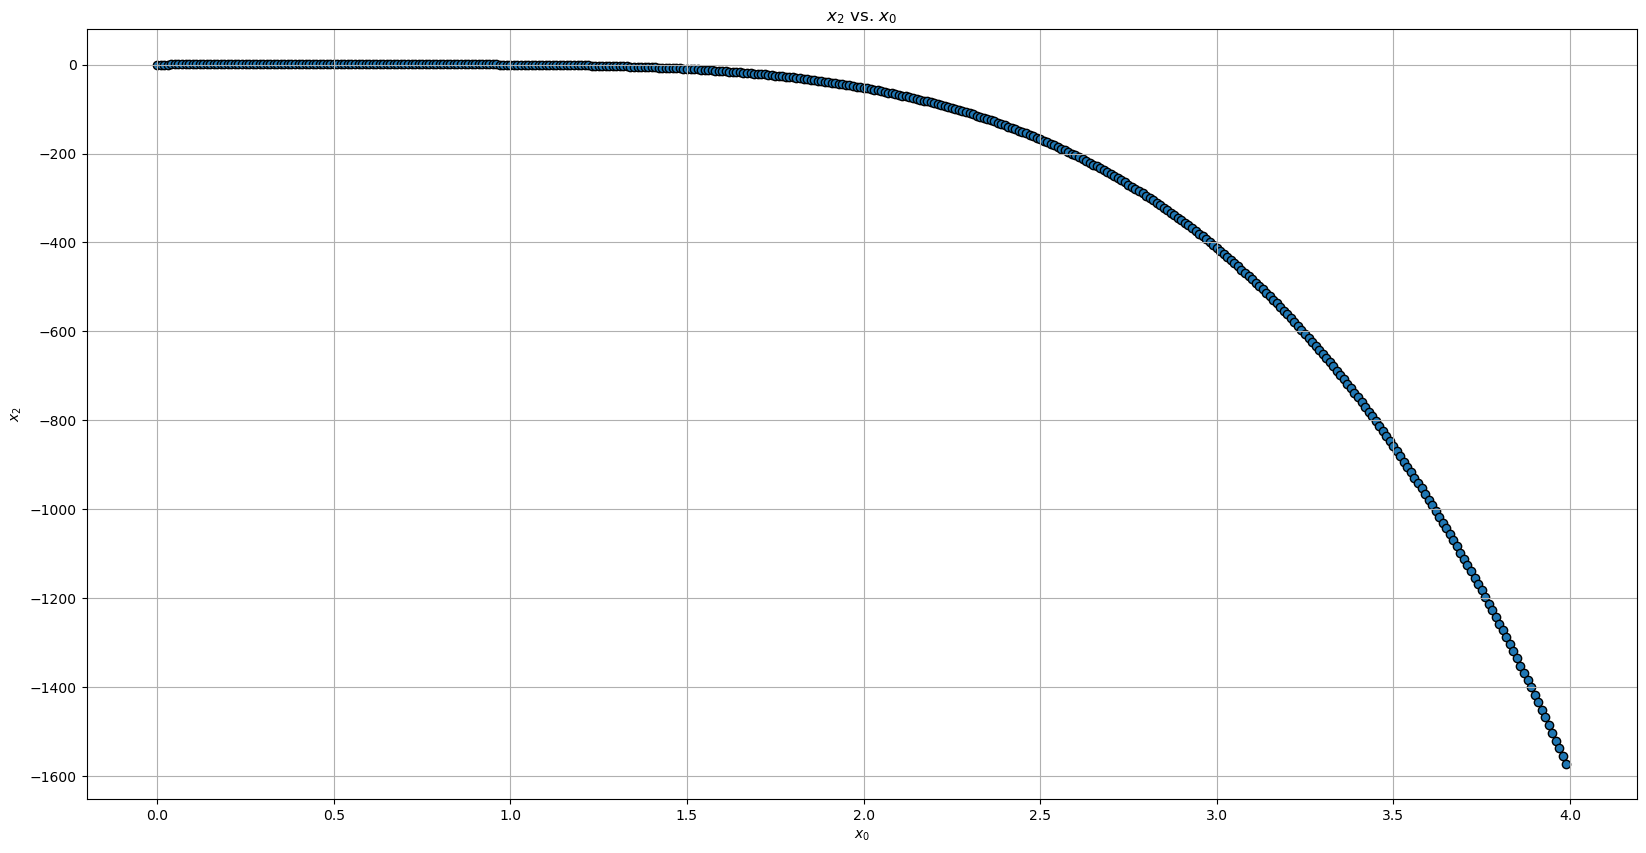

In [7]:
plt.figure(figsize=(20,10))
plt.scatter(xs_plot.cpu(), ys_plot.cpu(), marker='o', edgecolor='black');
plt.xlabel('$x_0$');
plt.ylabel('$x_2$');
plt.title('$x_2$ vs. $x_0$');
plt.grid();

In [8]:
from sklearn.model_selection import train_test_split

In [10]:
X, y = x_0s, ys_2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(0);

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [13]:
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=1)
test_dl = DataLoader(test_ds, batch_size=1)

In [14]:
train_ds[0]

(tensor(0.0300, device='cuda:0'), tensor(0.1318, device='cuda:0'))

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 3)
        self.layer2 = nn.Linear(3, 5)
        self.layer3 = nn.Linear(5, 3)
        self.layer4 = nn.Linear(3, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        return x

In [16]:
nn_model = NeuralNetwork(1, 1).to(device)

print(nn_model)

NeuralNetwork(
  (layer1): Linear(in_features=1, out_features=3, bias=True)
  (layer2): Linear(in_features=3, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=3, bias=True)
  (layer4): Linear(in_features=3, out_features=1, bias=True)
)


In [17]:
learning_rate = 0.001
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [18]:
num_epochs = 100
loss_hist = [0] * num_epochs

In [19]:
from tqdm.notebook import trange, tqdm

In [20]:
for epoch in trange(num_epochs):
    for x, y in train_dl:
        pred = nn_model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_hist[epoch] += loss.item()*y.size(0)
    loss_hist[epoch] /= len(train_dl.dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

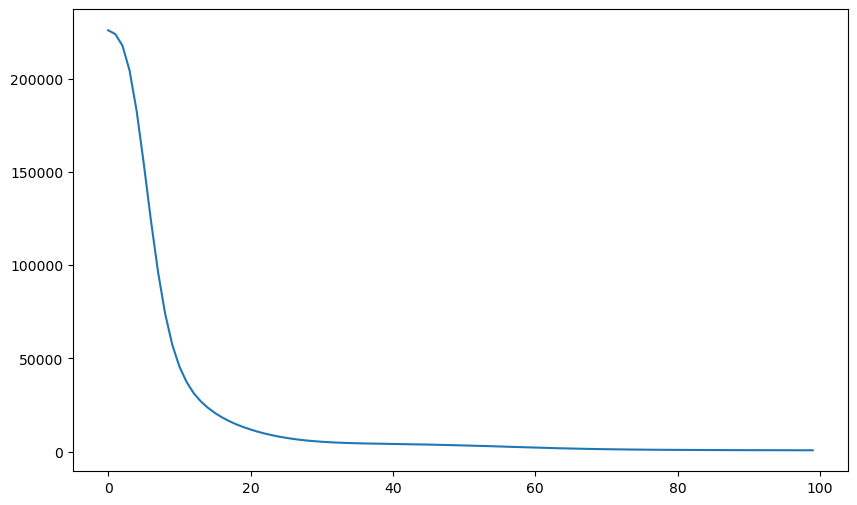

In [21]:
fig = plt.figure(figsize=(10, 6))
import matplotlib.pyplot as plt
plt.plot(loss_hist)

In [22]:
preds_on_test = [nn_model(torch.tensor(i, device=device)) for i,j in test_dl]
preds_plot = torch.tensor([preds_on_test[i].item() for i in range(len(preds_on_test))], device="cpu")

actual_on_test = [j for i,j in test_dl]
actual_test_plot = torch.tensor([actual_on_test[i].item() for i in range(len(actual_on_test))], device="cpu")

mse_test = nn.MSELoss()
print(f'Mean Squared Error: {mse_test(actual_test_plot, preds_plot).item()}')

Mean Squared Error: 546.01953125


/tmp/ipykernel_11177/1775855229.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_on_test = [nn_model(torch.tensor(i, device=device)) for i,j in test_dl]


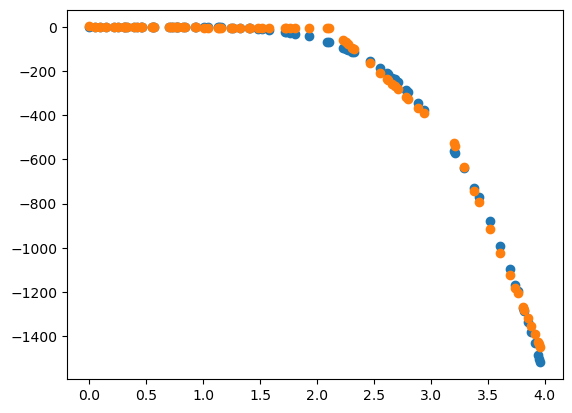

In [23]:
x_test = test_ds[:][0].to("cpu")
y_test = test_ds[:][1].to("cpu")

plt.scatter(x_test, y_test)
plt.scatter(x_test, preds_plot)